<a href="https://colab.research.google.com/github/jonatansg/CEIABD/blob/main/Actividad_3_4_%E2%80%93_Representacion_plot_de_datasets%2C_seleccion_de_caracteristicas_y_entrenamiento_de_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Autor:** Jonatan Santana González

El objetivo de esta actividad es poner en práctica los conocimientos adquiridos para el preprocesamiento de datos, selección de características y entrenamiento de modelos.

## 1. Describir el origen y breve explicación del Dataset, así como de cada una de las características.

El dataset **Car Evaluation** contiene información sobre la evaluación de automóviles basada en características como el precio, el mantenimiento, el número de puertas, la capacidad de pasajeros, el tamaño del maletero y la seguridad. El objetivo es clasificar los automóviles en una de las cuatro categorías:

* unacc: Inaceptable.
* acc: Aceptable.
* good: Bueno.
* vgood: Muy bueno.


Características:

1. buying: Precio de compra (vhigh, high, med, low).
2. maint: Costo de mantenimiento (vhigh, high, med, low).
3. doors: Número de puertas (2, 3, 4, 5more).
4. persons: Capacidad de pasajeros (2, 4, more).
5. lug_boot: Tamaño del maletero (small, med, big).
6. safety: Nivel de seguridad (low, med, high).

Origen: El dataset fue creado por Marko Bohanec y es ampliamente utilizado en tareas de clasificación.

In [ ]:
# Importación de librerías
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Cargar el dataset desde UCI Machine Learning Repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data"
column_names = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
df = pd.read_csv(url, names=column_names)
print(df.head())

  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


## 2. Procesamiento de datos en el dataset: ajustes en características con datos no informados, conversión de variables categóricas, etc…

In [ ]:
# Verificación de datos faltantes
print(df.isnull().sum())

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64


Convertimos las características categóricas a valores numéricos usando LabelEncoder:

In [ ]:
# Convertir variables categóricas a numéricas
le = LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])
print(df.head())

   buying  maint  doors  persons  lug_boot  safety  class
0       3      3      0        0         2       1      2
1       3      3      0        0         2       2      2
2       3      3      0        0         2       0      2
3       3      3      0        0         1       1      2
4       3      3      0        0         1       2      2


## 3. Utilizar las siguientes herramientas para la selección de características:

### 3.1. Matriz de gráficos de correlación.

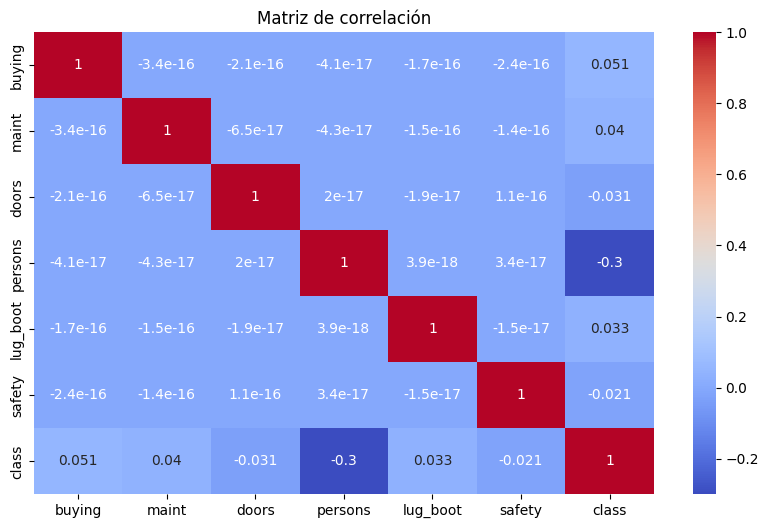

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

### 3.2. Matriz de gráficos de dispersión.

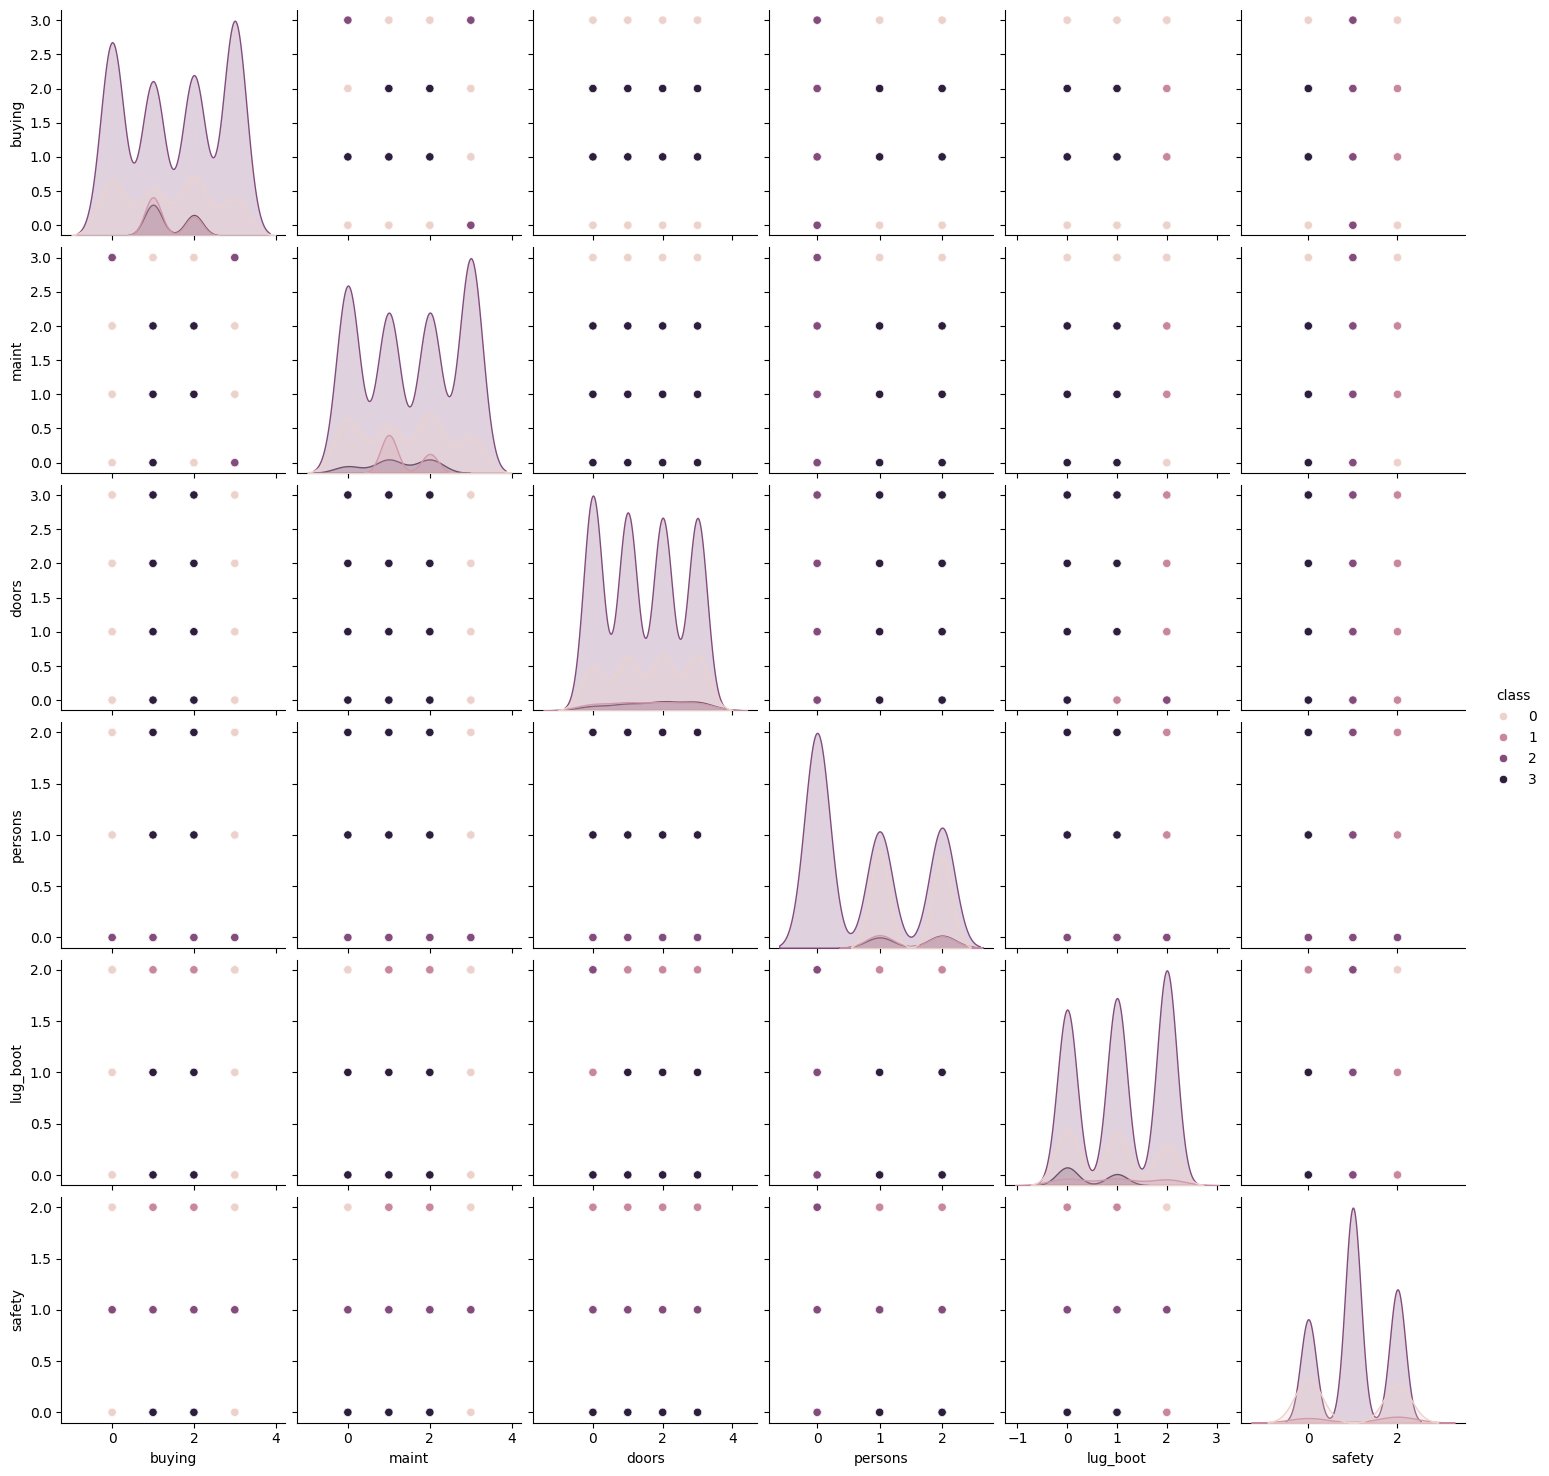

In [ ]:
sns.pairplot(df, hue="class")
plt.show()

### 3.3. SelectKBest.

Características seleccionadas: Index(['persons', 'lug_boot', 'safety'], dtype='object')


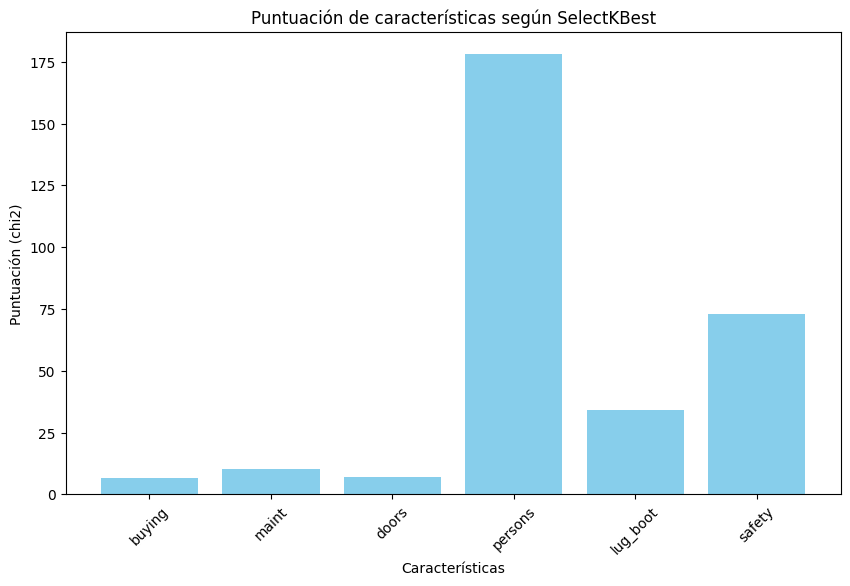

In [ ]:
# Separar características (X) y variable objetivo (y)
X = df.drop("class", axis=1)
y = df["class"]

# Aplicar SelectKBest con chi2
selector = SelectKBest(chi2, k=3)  # Seleccionar las 3 mejores características
X_new = selector.fit_transform(X, y)

# Obtener las características seleccionadas
selected_features = X.columns[selector.get_support()]
print("Características seleccionadas:", selected_features)

# Obtener las puntuaciones de cada característica
scores = selector.scores_

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(X.columns, scores, color='skyblue')
plt.xlabel("Características")
plt.ylabel("Puntuación (chi2)")
plt.title("Puntuación de características según SelectKBest")
plt.xticks(rotation=45)
plt.show()

## 4. Una pequeña reflexión sobre la elección de las características elegidas.

La selección de características con **SelectKBest** nos permite identificar las variables más relevantes para la clasificación de los datos en el conjunto "Car Evaluation". Al aplicar la prueba de **chi-cuadrado**, seleccionamos aquellas características que tienen la mayor dependencia con la variable objetivo (el tipo de automóvil: aceptable, bueno, muy bueno o inaceptable).

En este caso, las características elegidas pueden indicar qué factores tienen el mayor impacto en la decisión final sobre la evaluación del automóvil. Es probable que atributos como **safety (seguridad), persons (capacidad de pasajeros) y buying (precio de compra)** sean altamente relevantes, ya que la seguridad es un factor clave en la evaluación de un vehículo, la capacidad de pasajeros influye en su utilidad, y el precio de compra es determinante para la accesibilidad del consumidor.

Sin embargo, la exclusión de otras características no implica que sean irrelevantes, sino que su relación con la variable objetivo podría ser menos directa o estar mediada por otras variables. En modelos más avanzados, podríamos explorar métodos de selección más complejos o utilizar modelos basados en árboles de decisión que consideren interacciones entre características.

En conclusión, la elección de características es un paso crucial para reducir la dimensionalidad y mejorar el rendimiento del modelo, pero siempre debe complementarse con un análisis interpretativo para garantizar que las variables seleccionadas tengan sentido en el contexto del problema.

## 5. Librerías para NaiveBayes, entrenar el modelo que consideres más adecuado.

### 5.1. Sin utilizar Cross Validation.

In [ ]:
# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entrenar el modelo
model = GaussianNB()
model.fit(X_train, y_train)

# Predecir y evaluar
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.649325626204239
              precision    recall  f1-score   support

           0       0.48      0.09      0.16       118
           1       0.00      0.00      0.00        19
           2       0.84      0.84      0.84       358
           3       0.17      1.00      0.30        24

    accuracy                           0.65       519
   macro avg       0.37      0.48      0.32       519
weighted avg       0.70      0.65      0.63       519



### 5.1. Utilizando Cross Validation.

In [ ]:
# Usar Cross Validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

# Imprimir los resultados
print("Accuracy con Cross Validation:", scores.mean())
print("Puntuaciones de cada fold:", scores)

Accuracy con Cross Validation: 0.6058976292200721
Puntuaciones de cada fold: [0.64739884 0.62716763 0.55202312 0.6173913  0.58550725]


## 6. Obtener una conclusión sobre los resultados obtenidos en la predicción y evaluación al utilizar o no Cross Validation.

Los resultados obtenidos con el modelo **Gaussian Naive Bayes (GaussianNB)** muestran que, sin utilizar **Cross Validation (CV)**, el accuracy es de 64.9%, lo que podría sugerir un desempeño aceptable. Sin embargo, al analizar las métricas por clase, se observa que el modelo tiene un sesgo hacia la clase mayoritaria (clase **2**), con un buen desempeño en esta, pero un rendimiento muy pobre en las clases minoritarias (clases **0**, **1** y **3**). En particular, la clase **1** no se predice correctamente en absoluto, y la clase **0** tiene un recall extremadamente bajo, lo que indica que el modelo no identifica bien estas clases. Además, la clase **3** muestra un recall perfecto pero una precisión muy baja, sugiriendo una sobrepredicción de esta clase.

Al utilizar **Cross Validation**, el accuracy promedio disminuye a 60.5%, y las puntuaciones en cada fold varían entre 0.552 y 0.647, lo que indica que el modelo no generaliza bien a datos no vistos y que su desempeño es inconsistente. Esta disminución en el accuracy sugiere que el modelo podría estar sobreajustado cuando no se utiliza CV, ya que CV proporciona una evaluación más realista al considerar la variabilidad en los datos.

En conclusión, el modelo tiene dificultades para manejar el desbalance de clases, lo que afecta su capacidad para predecir correctamente las clases minoritarias. Además, el uso de Cross Validation revela que el modelo no generaliza bien y que su desempeño es menos robusto de lo que podría parecer sin CV. Para mejorar los resultados, sería necesario abordar el desbalance de clases y considerar técnicas de preprocesamiento o modelos alternativos que puedan manejar mejor esta situación.

## 7. Además de las herramientas indicadas anteriormente, se valorará la utilización de alguna otra herramienta o técnica no vista en el curso para la selección de las características.

In [ ]:
!pip install boruta

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	6
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	5
Tentative: 	1
Rejected: 	0
Iteration: 	17 / 

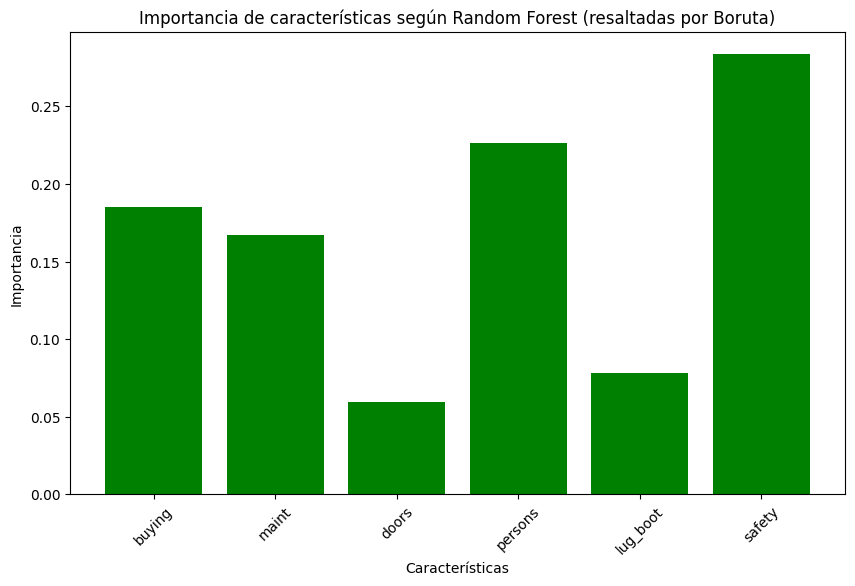

In [ ]:
# Inicializar Boruta
rf = RandomForestClassifier(random_state=42)
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

# Aplicar Boruta
boruta.fit(X.values, y.values)

# Obtener las características seleccionadas
selected_features = X.columns[boruta.support_]
print("Características seleccionadas con Boruta:", selected_features)

# Entrenar un modelo de Random Forest por separado para obtener la importancia de las características
rf_separado = RandomForestClassifier(random_state=42)
rf_separado.fit(X, y)

# Obtener la importancia de las características según Random Forest
feature_importance = rf_separado.feature_importances_

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(X.columns, feature_importance, color='orange')

# Resaltar las características seleccionadas por Boruta
for i, feature in enumerate(X.columns):
    if boruta.support_[i]:
        plt.bar(i, feature_importance[i], color='green')  # Características seleccionadas en verde

# Añadir etiquetas y título
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.title("Importancia de características según Random Forest (resaltadas por Boruta)")
plt.xticks(rotation=45)
plt.show()

**Conclusión:** El análisis de importancia de características con **Boruta y Random Forest** muestra que las variables más relevantes para la clasificación son **safety**, **persons**, **buying** y **maint**, mientras que **doors** y **lug_boot** tienen menor impacto. Esto sugiere que la seguridad y el número de personas que puede transportar el vehículo son factores clave en la decisión de clasificación, lo que tiene sentido desde una perspectiva práctica. En contraste, el número de puertas y el tamaño del maletero parecen tener un peso menor, posiblemente porque no afectan directamente a la evaluación general del vehículo en términos de seguridad y costos de mantenimiento. Esto indica que un modelo simplificado podría beneficiarse de enfocarse en las características más significativas sin perder demasiada precisión.